In [1]:
import argparse
import collections
import functools
import json
import imageio
import os
import pathlib
import sys
import time
from PIL import Image
import skvideo.io
import matplotlib

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['MUJOCO_GL'] = 'egl'

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.mixed_precision import experimental as prec
from blox.utils import AverageMeter, timing
from blox.basic_types import map_dict
import time
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

from tensorflow_probability import distributions as tfd

from utils import models, tools, wrappers, logging
from dreamer import Dreamer, preprocess, make_bare_env
import dreamer
from planners import gn_solver, gn_solver_goal
from dreamer_colloc import DreamerColloc, make_env
import dreamer_colloc

def define_config():
  config = dreamer_colloc.define_config()
  return config

Choosing the latest nvidia driver: /usr/lib/nvidia-418, among ['/usr/lib/nvidia-375', '/usr/lib/nvidia-418']
Choosing the latest nvidia driver: /usr/lib/nvidia-418, among ['/usr/lib/nvidia-375', '/usr/lib/nvidia-418']


No module named 'flow'
No module named 'carla'


In [2]:
# Parse arguments
try:
  import colored_traceback
  colored_traceback.add_hook()
except ImportError:
  pass
parser = argparse.ArgumentParser()
for key, value in define_config().items():
  parser.add_argument(f'--{key}', type=tools.args_type(value), default=value)
# args = \
# '--logdir ./logdir/mw_pickplace/dreamer_vis_online_gd200_fixed \
# --task mw_sawyer_SawyerPickPlaceEnvV2 \
# --action_repeat 1 \
# --time_limit 120 \
# --planning_task colloc_second_order \
# --planning_horizon 40 \
# --mpc_steps 40 \
# --gd_steps 200 \
# --logdir_colloc ./logdir_colloc/mw_pickplace/dreamer_vis_online_gd200_fixed \
# --rew_res_wt 1 \
# --dyn_threshold 1e-5 \
# --act_threshold 1e-5 \
# --coeff_normalization 1 \
# --eval_tasks 1 \
# --collect_sparse_reward True \
# --state_regressor True \
# --use_sparse_reward True'

# args = \
# '--logdir ./logdir/mw_push/dreamer_vis_online_gd200_fixed \
# --task mw_sawyer_SawyerPushEnvV2 \
# --action_repeat 1 \
# --time_limit 120 \
# --planning_task colloc_second_order \
# --planning_horizon 40 \
# --mpc_steps 20 \
# --gd_steps 200 \
# --logdir_colloc ./logdir_colloc/mw_push/1 \
# --rew_res_wt 1 \
# --dyn_threshold 1e-5 \
# --act_threshold 1e-5 \
# --coeff_normalization 1 \
# --eval_tasks 1 \
# --collect_sparse_reward True \
# --state_regressor True \
# --use_sparse_reward True'
args = '--logdir ./logdir/mw_push/collect_sparse_rewards_300k --task mw_sawyer_SawyerPushEnvV2 --action_repeat=1 --time_limit=30 --batch_length=20'
config = parser.parse_args(args.split(' '))

if config.gpu_growth:
  for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
assert config.precision in (16, 32), config.precision
if config.precision == 16:
  prec.set_policy(prec.Policy('mixed_float16'))
config.steps = int(config.steps)
config.logdir.mkdir(parents=True, exist_ok=True)
print('Logdir', config.logdir)
config.logdir_colloc.mkdir(parents=True, exist_ok=True)

Logdir logdir/mw_push/collect_sparse_rewards_300k


In [3]:
# Create environment.
env = make_env(config)

# Create visualization environment
suite, task = config.task.split('_', 1)
vis_env = wrappers.MetaWorldVis(task, config.action_repeat, width=64)

# Create and load agent.
actspace = env.action_space
datadir = config.logdir / 'episodes'
agent = DreamerColloc(config, datadir, actspace)
agent.load(config.logdir / 'variables.pkl')

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Found 5296420 model parameters.
Found 576808 actor parameters.
Found 413601 value parameters.


## Reward field

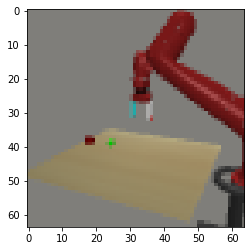

In [4]:
state = np.array([0., 0., 0.02, 0., 0., 0.02, 0, 0, 0])
state = np.array([0.1, 0.6, 0.25, 0.0, 0.25, 0.0, -0.0, 0.0, -0.0])
state[:3] += np.array([0.0, 0.0, 0.0]) # xyz Sawyer
state[3:6] += np.array([0.1, 0.7, 0.0]) # xyz object
# Table is [-.35, .35], [.25, .95]
frame = vis_env.render_states(state[None])
# np.save(config.logdir_colloc / 'background.npy', frame[0])
feat = agent.get_init_feat({'image': frame, 'reward': np.zeros(1)})[0]
r = agent._reward(feat).mode()
plt.imshow(frame[0])
plt.show()

In [76]:
def get_r(x, y):
    state = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0])
    state[:3] += np.array([x, y, 0.0]) # xyz Sawyer
#     state[:3] += np.array([0.1, 0.6, 0.0]) # Sawyer in neutral position
    state[3:6] += np.array([x, y, 0.0]) # xyz object
    # Table is [-.35, .35], [.25, .95]
    frame = vis_env.render_states(state[None])
    
    feat = agent.get_init_feat({'image': frame, 'reward': np.zeros(1)})[0]
    r = agent._reward(feat).mode()
    return r

n = 30
reward_map = np.zeros((n,n))
for i, x in enumerate(np.linspace(-.35, .35, n)):
    for j, y in enumerate(np.linspace(.25, .95, n)):
        r = get_r(x,y)
        reward_map[i,j] = r

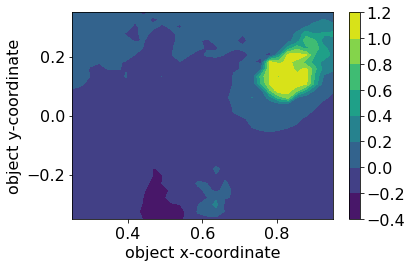

In [127]:
x, y = np.meshgrid(np.linspace(.25, .95, n),
                   np.linspace(-.35, .35, n))

cmap = plt.get_cmap()
# plt.contourf(y_map, x_map, reward_map, 100, cmap=cmap)
fig = plt.figure()
matplotlib.rcParams.update({'font.size': 16})
plt.contourf(x, y, reward_map, cmap=cmap)
# plt.imshow(reward_map)
# plt.contourf(y_map, x_map, reward_map, cmap=cmap)
# plt.contourf(reward_map)
# plt.pcolormesh(reward_map)
plt.colorbar()
fig.show()
plt.xlabel('object x-coordinate')
plt.ylabel('object y-coordinate')
plt.tight_layout()
fig.savefig("reward_field.png", dpi=300)